In [1]:
import numpy as np
import cupy as cp
from numba import jit, prange
import timeit
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from cupyx.scipy.sparse import coo_matrix as cp_coo_matrix

In [2]:
def ss_base(mat1, mat2, c):
    res = mat1 + mat2*c
    
def ss_cp(mat1, mat2, c):
    res = mat1 + mat2*c
    
@jit(nopython=True, parallel=True)
def ss_nb(A, iA, jA, B, iB, jB, c, C, iC, jC):
    n = len(iA) - 1
    for row in prange(n):
        for i in prange(iB[row], iB[row+1]):
            left = int(iA[row])
            right = int(iA[row+1]-1)
            while left <= right:
                mid = int((left+right) / 2)
                if jA[mid] < jB[i]:
                    left = mid + 1
                elif jA[mid] > jB[i]:
                    right = mid - 1
                else:
                    # jA[mid] == jB[i]
                    C[mid] += B[i]*c
                    break    

In [3]:
N = [int(8*(2**0.5)**i) for i in range(28)]
methods = ["ss_base", "ss_cp", "ss_nb"]
K = len(methods)
funcs = [ss_base, ss_cp, ss_nb]
masks = [1, 1, 1]
groups = [0, 0, 0]
T = [[] for i in range(K)]
deg = 40
obtain = 1000
for n in N:
    print("Start with size:", n)
    row, col = np.random.randint(0, n, (2, n*deg))
    data1, data2 = np.random.rand(2, n*deg)
    c = np.random.rand()
    
    choose = np.random.randint(0, n*deg, (obtain))
    row2 = row[choose]
    col2 = col[choose]
    data2 = data2[choose]
    
    mat1 = csr_matrix((data1,(row, col)), shape=(n,n))
    cmat1 = cp_coo_matrix((cp.array(data1), (cp.array(row), cp.array(col))), shape=(n,n)).tocsr()
    mat2 = csr_matrix((data2,(row2, col2)), shape=(n,n))
    cmat2 = cp_coo_matrix((cp.array(data2), (cp.array(row2), cp.array(col2))), shape=(n,n)).tocsr()
    
    res = np.zeros(n)
    C = np.copy(mat1.data)
    iC = np.copy(mat1.indptr)
    jC = np.copy(mat1.indices)
    args = [(mat1, mat2, c), (cmat1, cmat2, c), (mat1.data, mat1.indptr, mat1.indices, mat2.data, mat2.indptr, mat2.indices, c, C, iC, jC)]
    
    for i in range(K):
        t = %timeit -q -n 1 -r 1 -o funcs[i](*args[i])
        T[i].append(t.average*1000)
        
    res = mat1 + mat2*c
    res2 = csr_matrix((C, jC, iC), shape=(n, n))
    zero = res2-res
    print(np.sum(zero))

Start with size: 8
0.0
Start with size: 11
0.0
Start with size: 16
0.0
Start with size: 22
0.0
Start with size: 32
0.0
Start with size: 45
0.0
Start with size: 64
0.0
Start with size: 90
0.0
Start with size: 128
0.0
Start with size: 181
0.0
Start with size: 256
0.0
Start with size: 362
0.0
Start with size: 512
0.0
Start with size: 724
0.0
Start with size: 1024
0.0
Start with size: 1448
0.0
Start with size: 2048
0.0
Start with size: 2896
0.0
Start with size: 4096
0.0
Start with size: 5792
0.0
Start with size: 8192
0.0
Start with size: 11585
0.0
Start with size: 16384
0.0
Start with size: 23170
0.0
Start with size: 32768
0.0
Start with size: 46340
0.0
Start with size: 65536
0.0
Start with size: 92681
0.0


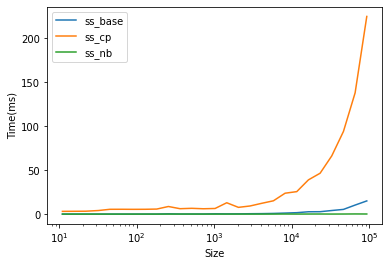

In [4]:
n_groups = max(groups)+1
fig, axs = plt.subplots(n_groups)
plt.rcParams["figure.figsize"] = (10,15)
if n_groups == 1:
    for i in range(K):
        if masks[i]:
            axs.plot(N[1:], T[i][1:], label=methods[i])
    axs.set_xlabel("Size")
    axs.set_ylabel("Time(ms)")
    axs.legend()
    axs.set_xscale('log')
else:
    for g in range(n_groups):
        for i in range(K):
            if masks[i] and groups[i] == g:
                axs[g].plot(N[1:], T[i][1:], label=methods[i])
        axs[g].set_xlabel("Size")
        axs[g].set_ylabel("Time(ms)")
        axs[g].legend()
        axs[g].set_xscale('log')
plt.show()

In [5]:
print(T)

[[0.23066599896992557, 0.1577099992573494, 0.15029700080049224, 0.15365799845312722, 0.15985600111889653, 0.15916600023047067, 0.16372600111935753, 0.1654110001254594, 0.1705349986877991, 0.18446100148139521, 0.449305998699856, 0.22268099928623997, 0.23017300009087194, 0.2495579992682906, 0.47921300028974656, 0.369420000424725, 0.40852699930837844, 0.5603259996860288, 0.6660819999524392, 0.8897399984562071, 1.2899180001113564, 1.734588999170228, 2.7737279997381847, 2.845102000719635, 4.200624000077369, 5.452892999528558, 10.37649899990356, 15.095284999915748], [3.8725009999325266, 3.235272000893019, 3.333915999974124, 3.4093680005753413, 4.1750660002435325, 5.569105000176933, 5.603280000286759, 5.5374650000885595, 5.587278999882983, 5.832086000737036, 8.757112000239431, 6.252866000068025, 6.687770001008175, 6.186880998939159, 6.505049001134466, 13.015520000408287, 7.7831599992350675, 9.348380999654182, 12.390613999741618, 15.235754000968882, 23.856235999119235, 25.655448000179604, 39.0